# 🎯 СИСТЕМА УПРАВЛЕНИЯ КРЕДИТНЫМ ПОРТФЕЛЕМ
## Демонстрация для презентации на семинаре

**Автор:** Кирякин М.С.  
**Тема:** Применение модели Мертона для управления кредитными рисками

---

### 📋 Структура презентации:
1. **Часть 1:** Настройка системы и сравнение эффективности
2. **Часть 2:** Процесс принятия решений и лимиты
3. **Часть 3:** Макроэкономические шоки и оптимизация

---

## 🔧 ЧАСТЬ 1: НАСТРОЙКА СИСТЕМЫ И БАЗОВЫЕ РАСЧЕТЫ

In [2]:
# Импорт всех необходимых библиотек
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import logging
import os
import sys

# Настройка стилей
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

print("✅ Библиотеки загружены")

✅ Библиотеки загружены


In [3]:
# Импорт данных из основного проекта
from utils.LabelsDict import tickers
from utils.load_data import *
from utils.portfolio import Portfolio

# Настройка логирования (упрощенная для презентации)
logging.basicConfig(level=logging.INFO, format='%(message)s')
log = logging.getLogger(__name__)

print("✅ Модули проекта загружены")

✅ Модули проекта загружены


In [4]:
# Создание портфеля на основе тех же данных, что и в main.ipynb
tickers_list = [
    'GAZP', 'LKOH', 'ROSN',  # Нефтегазовый сектор
    'SBER', 'VTBR', 'MOEX', # Финансовый сектор
    'GMKN', 'NLMK', 'RUAL', # Металлургия
    'MTSS', 'RTKM', 'TTLK', # Телеком
    'MGNT', 'LNTA', 'FESH', # Ритейл
]

print(f"📊 Анализируемые компании: {len(tickers_list)}")
print(f"🏢 Тикеры: {', '.join(tickers_list)}")

# Создаем портфель точно как в main.ipynb
portfolio = Portfolio(
    dt_calc='2025-05-31',
    dt_start='2019-11-03', 
    stocks_step=10,
    tickers_list=tickers_list
)

print("✅ Портфель создан")

📊 Анализируемые компании: 15
🏢 Тикеры: GAZP, LKOH, ROSN, SBER, VTBR, MOEX, GMKN, NLMK, RUAL, MTSS, RTKM, TTLK, MGNT, LNTA, FESH
✅ Портфель создан


In [5]:
# Загрузка и подготовка данных (как в main.ipynb)
print("🔄 Загрузка рыночных данных...")
portfolio = (
    portfolio
    .load_stock_data(
        use_backup_data=True,
        create_backup=False
    )
    .load_multipliers()
    .create_portfolio()
    .adjust_portfolio_data_types()
    .add_macro_data()
    .fill_missing_values()
    .add_dynamic_features()
    .add_merton_pd()
)

print("✅ Данные загружены и обработаны")
print(f"📅 Период анализа: {portfolio.dt_start} - {portfolio.dt_calc}")
print(f"🎯 Модель: Merton Model для расчета PD")

🔄 Загрузка рыночных данных...
Stocks data loaded from backup | Records: %d 855
Multipliers data loaded | Features: %s ['ticker', 'year', 'quarter', 'EV/EBITDA', 'P/BV', 'P/E', 'P/FCF', 'P/S', 'Долг, млрд руб', 'Долг/EBITDA', 'Капитализация, млрд руб', 'Чистый долг, млрд руб']
Portfolio created | Companies: %d 15
Column types adjusted: %s ['Долг, млрд руб', 'Капитализация, млрд руб', 'Чистый долг, млрд руб', 'high', 'low', 'close', 'EV/EBITDA', 'P/BV', 'P/E', 'P/S', 'open', 'Долг/EBITDA']
2025-11-04 21:00:33,846:utils.load_data:INFO: Backup file for usd/rub exchange rates was updated.New dates range: 2019-11-03 : 2025-05-31
Macro indicators added: Interest rate, Unemployment, Inflation, USD/RUB
Missing values share in: Debt (33.6 %),Cap (13.0 %), USD/RUB (0.0 %)
Missing values filled in: ['debt', 'capitalization', 'rubusd_exchange_rate']
Capital cost and capital volatility calculated.
Merton's probabilities of default calculated.
✅ Данные загружены и обработаны
📅 Период анализа: 2019-11

### 📊 АНАЛИЗ ТЕКУЩЕГО СОСТОЯНИЯ ПОРТФЕЛЯ

In [6]:
# Получение текущих PD всех компаний (как в main.ipynb)
# Извлекаем последние значения PD для каждой компании
current_pd_stats = portfolio.portfolio.groupby('ticker')['PD'].last()
print(f"Статистики PD загружены для {len(current_pd_stats)} компаний")
print(f"Средняя PD: {current_pd_stats.mean()*100:.2f}%")

# Создаем DataFrame для анализа
current_pds = current_pd_stats.to_dict()
pd_df = pd.DataFrame([
    {'Ticker': ticker, 'PD': pd_val, 'PD_percent': pd_val * 100}
    for ticker, pd_val in current_pds.items()
]).sort_values('PD', ascending=False)

print("\n📈 ТЕКУЩИЕ ЗНАЧЕНИЯ PD ПО КОМПАНИЯМ:")
print(pd_df.round(4))

# Статистика
print(f"\n📊 СТАТИСТИКА ПОРТФЕЛЯ:")
print(f"   • Средняя PD: {pd_df['PD'].mean():.3f} ({pd_df['PD'].mean()*100:.1f}%)")
print(f"   • Медиана PD: {pd_df['PD'].median():.3f} ({pd_df['PD'].median()*100:.1f}%)")
print(f"   • Максимальная PD: {pd_df['PD'].max():.3f} ({pd_df['PD'].max()*100:.1f}%)")
print(f"   • Минимальная PD: {pd_df['PD'].min():.3f} ({pd_df['PD'].min()*100:.1f}%)")

Статистики PD загружены для 15 компаний
Средняя PD: 0.04%

📈 ТЕКУЩИЕ ЗНАЧЕНИЯ PD ПО КОМПАНИЯМ:
   Ticker      PD  PD_percent
14   VTBR  0.0030      0.2954
1    GAZP  0.0010      0.1046
10   RTKM  0.0006      0.0561
7    MTSS  0.0003      0.0334
4    LNTA  0.0003      0.0283
11   RUAL  0.0002      0.0221
2    GMKN  0.0000      0.0024
5    MGNT  0.0000      0.0009
9    ROSN  0.0000      0.0006
12   SBER  0.0000      0.0001
6    MOEX  0.0000      0.0000
0    FESH  0.0000      0.0000
8    NLMK  0.0000      0.0000
3    LKOH  0.0000      0.0000
13   TTLK  0.0000      0.0000

📊 СТАТИСТИКА ПОРТФЕЛЯ:
   • Средняя PD: 0.000 (0.0%)
   • Медиана PD: 0.000 (0.0%)
   • Максимальная PD: 0.003 (0.3%)
   • Минимальная PD: 0.000 (0.0%)


### 🔥 КЛЮЧЕВОЙ ГРАФИК: УПРАВЛЯЕМЫЙ VS НЕУПРАВЛЯЕМЫЙ ПОРТФЕЛЬ

In [7]:
# Анализ реальных исторических данных PD из портфеля
print("🔍 Анализ исторических данных PD...")

# Получаем все данные портфеля с PD
portfolio_data = portfolio.portfolio.copy()

# Проверяем структуру данных
print(f"📊 Размер портфеля: {portfolio_data.shape}")
print(f"📅 Диапазон дат: {portfolio_data['date'].min()} - {portfolio_data['date'].max()}")
print(f"🏢 Компании: {portfolio_data['ticker'].unique()}")
print(f"📈 Колонки: {list(portfolio_data.columns)}")

# Смотрим на распределение PD по времени
print(f"\n📊 Статистика PD:")
print(f"   • Среднее: {portfolio_data['PD'].mean():.4f}")
print(f"   • Медиана: {portfolio_data['PD'].median():.4f}")
print(f"   • Мин: {portfolio_data['PD'].min():.4f}")
print(f"   • Макс: {portfolio_data['PD'].max():.4f}")

# Создаем временные ряды для каждой компании
print(f"\n📈 Последние значения PD по компаниям:")
for ticker in tickers_list:
    if ticker in portfolio_data['ticker'].values:
        ticker_data = portfolio_data[portfolio_data['ticker'] == ticker].sort_values('date')
        if not ticker_data.empty:
            latest_pd = ticker_data['PD'].iloc[-1]
            print(f"   {ticker}: {latest_pd:.4f} ({latest_pd*100:.2f}%)")
    else:
        print(f"   {ticker}: Данные отсутствуют")

🔍 Анализ исторических данных PD...
📊 Размер портфеля: (855, 24)
📅 Диапазон дат: 2019-12-31 00:00:00 - 2024-10-31 00:00:00
🏢 Компании: ['FESH' 'GAZP' 'GMKN' 'LKOH' 'LNTA' 'MGNT' 'MOEX' 'MTSS' 'NLMK' 'ROSN'
 'RTKM' 'RUAL' 'SBER' 'TTLK' 'VTBR']
📈 Колонки: ['ticker', 'date', 'time', 'open', 'high', 'low', 'close', 'quarter', 'year', 'EV/EBITDA', 'P/BV', 'P/E', 'P/FCF', 'P/S', 'debt', 'Долг/EBITDA', 'capitalization', 'interest_rate', 'inflation', 'Year', 'unemployment_rate', 'rubusd_exchange_rate', 'quarterly_volatility', 'PD']

📊 Статистика PD:
   • Среднее: 0.0003
   • Медиана: 0.0000
   • Мин: 0.0000
   • Макс: 0.0077

📈 Последние значения PD по компаниям:
   GAZP: 0.0010 (0.10%)
   LKOH: 0.0000 (0.00%)
   ROSN: 0.0000 (0.00%)
   SBER: 0.0000 (0.00%)
   VTBR: 0.0030 (0.30%)
   MOEX: 0.0000 (0.00%)
   GMKN: 0.0000 (0.00%)
   NLMK: 0.0000 (0.00%)
   RUAL: 0.0002 (0.02%)
   MTSS: 0.0003 (0.03%)
   RTKM: 0.0006 (0.06%)
   TTLK: 0.0000 (0.00%)
   MGNT: 0.0000 (0.00%)
   LNTA: 0.0003 (0.03%)
 

In [1]:
from tqdm import tqdm

In [ ]:
# РЕАЛЬНАЯ СИСТЕМА УПРАВЛЕНИЯ ПОРТФЕЛЕМ С РЕБАЛАНСИРОВКОЙ
#print("🔄 Создание системы управления на основе реальных данных и методов портфеля...")

# Шаг 1: Настройка системы управления рисками (как в main.ipynb)
# print("\n📋 ЭТАП 1: Настройка системы кредитного риска")
# credit_manager = portfolio

# # Устанавливаем консервативные банковские лимиты
# credit_manager.create_credit_risk_limits(
#     max_pd_threshold=0.05,           # 5% - максимальная PD для одобрения
#     max_sector_concentration=0.25,   # 25% - максимум в одном секторе  
#     max_single_exposure=0.08         # 8% - максимум на одного заемщика
# )

# print("✅ Лимиты риска установлены:")
# print(f"   • Максимальная PD: {credit_manager.credit_limits['max_pd_threshold']*100}%")
# print(f"   • Секторная концентрация: {credit_manager.credit_limits['max_sector_concentration']*100}%")
# print(f"   • Доля одного заемщика: {credit_manager.credit_limits['max_single_exposure']*100}%")

# # Шаг 2: Создаем кредитные заявки на основе реальных компаний из портфеля
# print(f"\n📝 ЭТАП 2: Генерация кредитных заявок")

# # Берем реальные компании из портфеля и их текущие PD
# portfolio_data = portfolio.portfolio.copy()
# latest_data = portfolio_data.groupby('ticker').last().reset_index()

# # Создаем заявки на кредиты
# credit_applications = []
# portfolio_budget = 1000  # млн руб

# for _, row in tqdm(latest_data.iterrows()):
#     ticker = row['ticker']
#     if ticker in tickers_list[:10]:  # Берем первые 10 компаний
#         # Случайная сумма кредита (реалистичная)
#         np.random.seed(hash(ticker) % 100)  # Детерминированная случайность
#         amount = np.random.uniform(50, 200)  # млн руб
#         rate = 0.08 + np.random.uniform(0.02, 0.08)  # ставка 8-16%
        
#         credit_applications.append({
#             'ticker': ticker,
#             'amount': amount,
#             'rate': rate,
#             'current_pd': row['PD']
#         })

# total_requested = sum(app['amount'] for app in credit_applications)
# print(f"📊 Создано {len(credit_applications)} кредитных заявок")
# print(f"💰 Общий запрос: {total_requested:.1f} млн руб.")
# print(f"🏦 Доступный бюджет: {portfolio_budget:.0f} млн руб.")
# print(f"📈 Перепрос к бюджету: {total_requested/portfolio_budget:.1f}x")

# # Шаг 3: Обработка заявок БЕЗ системы управления (простое одобрение по PD)
# print(f"\n🚨 СЦЕНАРИЙ БЕЗ УПРАВЛЕНИЯ:")
# unmanaged_portfolio = []
# unmanaged_budget = portfolio_budget
# unmanaged_allocated = 0

# for app in credit_applications:
#     if app['current_pd'] <= 0.07 and unmanaged_allocated + app['amount'] <= unmanaged_budget:  # Простой лимит 7%
#         unmanaged_portfolio.append(app)
#         unmanaged_allocated += app['amount']

# if unmanaged_portfolio:
#     unmanaged_pd = sum(app['amount'] * app['current_pd'] for app in unmanaged_portfolio) / unmanaged_allocated
#     unmanaged_return = sum(app['amount'] * app['rate'] for app in unmanaged_portfolio) / unmanaged_allocated
    
# print(f"✅ Без управления - размещено: {len(unmanaged_portfolio)} кредитов на {unmanaged_allocated:.1f} млн руб.")
# print(f"📊 Портфельная PD: {unmanaged_pd*100:.2f}%")
# print(f"? Портфельная доходность: {unmanaged_return*100:.2f}%")

In [ ]:
# Шаг 4: Применение СИСТЕМЫ УПРАВЛЕНИЯ с ребалансировкой
print(f"\n✅ СЦЕНАРИЙ С СИСТЕМОЙ УПРАВЛЕНИЯ:")

# Обрабатываем каждую заявку через систему управления рисками
managed_decisions = []

for app in credit_applications:
    try:
        # Используем реальный метод assess_credit_application из класса Portfolio
        decision = credit_manager.assess_credit_application(
            borrower_ticker=app['ticker'],
            loan_amount=app['amount'] * 1e6,  # переводим в рубли для метода
            current_portfolio_size=portfolio_budget * 1e6
        )
        
        managed_decisions.append({
            **app,
            'decision': decision['decision'],
            'pd': decision['pd'],
            'risk_rating': decision['risk_rating'],
            'recommended_rate': decision['recommended_rate'],
            'exposure_ratio': decision['exposure_ratio'],
            'sector': decision['sector'],
            'reason': decision['reason']
        })
        
    except Exception as e:
        print(f"⚠️ Ошибка обработки {app['ticker']}: {e}")
        # Фолбэк для проблемных тикеров
        managed_decisions.append({
            **app,
            'decision': 'ОТКЛОНИТЬ',
            'pd': app['current_pd'],
            'risk_rating': 'N/A',
            'recommended_rate': 0.15,
            'exposure_ratio': 0,
            'sector': 'Неизвестно',
            'reason': 'Ошибка оценки'
        })

# Фильтруем одобренные заявки
approved_loans = [d for d in managed_decisions if d['decision'] in ['ОДОБРИТЬ', 'УСЛОВНО ОДОБРИТЬ']]
rejected_loans = [d for d in managed_decisions if d['decision'] == 'ОТКЛОНИТЬ']

print(f"📋 РЕЗУЛЬТАТЫ ОБРАБОТКИ ЗАЯВОК:")
print(f"   ✅ Одобрено: {len(approved_loans)} заявок")
print(f"   ❌ Отклонено: {len(rejected_loans)} заявок")

# Создаем оптимальный портфель с учетом лимитов
managed_portfolio = []
managed_allocated = 0
sector_allocations = {}

# Сортируем одобренные заявки по риск-скорректированной доходности
for loan in approved_loans:
    risk_adjusted_return = loan['recommended_rate'] - loan['pd']
    loan['risk_adjusted_return'] = risk_adjusted_return

approved_loans.sort(key=lambda x: x['risk_adjusted_return'], reverse=True)

# Формируем портфель с соблюдением лимитов
for loan in approved_loans:
    if managed_allocated + loan['amount'] <= portfolio_budget:
        # Проверяем секторный лимит
        sector = loan['sector']
        current_sector_alloc = sector_allocations.get(sector, 0)
        new_sector_total = current_sector_alloc + loan['amount']
        
        if new_sector_total / portfolio_budget <= credit_manager.credit_limits['max_sector_concentration']:
            # Проверяем лимит на одного заемщика
            if loan['amount'] / portfolio_budget <= credit_manager.credit_limits['max_single_exposure']:
                managed_portfolio.append(loan)
                managed_allocated += loan['amount']
                sector_allocations[sector] = new_sector_total

if managed_portfolio:
    managed_pd = sum(loan['amount'] * loan['pd'] for loan in managed_portfolio) / managed_allocated
    managed_return = sum(loan['amount'] * loan['recommended_rate'] for loan in managed_portfolio) / managed_allocated
    
print(f"\n💰 С УПРАВЛЕНИЕМ - размещено: {len(managed_portfolio)} кредитов на {managed_allocated:.1f} млн руб.")
print(f"📊 Портфельная PD: {managed_pd*100:.2f}%")
print(f"📈 Портфельная доходность: {managed_return*100:.2f}%")
print(f"🎯 Риск-премия: {(managed_return - managed_pd)*100:.2f}%")
print(f"📋 Использование бюджета: {managed_allocated/portfolio_budget*100:.1f}%")

# Показываем состав управляемого портфеля
print(f"\n🏢 СОСТАВ УПРАВЛЯЕМОГО ПОРТФЕЛЯ:")
for loan in managed_portfolio:
    share = loan['amount'] / managed_allocated
    print(f"   {loan['ticker']}: {loan['amount']:.1f} млн ({share*100:.1f}%) | " +
          f"PD: {loan['pd']*100:.1f}% | Ставка: {loan['recommended_rate']*100:.1f}% | {loan['sector']}")

print(f"\n📊 СЕКТОРНАЯ ДИВЕРСИФИКАЦИЯ:")
for sector, amount in sector_allocations.items():
    share = amount / managed_allocated
    print(f"   {sector}: {amount:.1f} млн руб. ({share*100:.1f}%)")

# Сравнение эффективности
if unmanaged_portfolio and managed_portfolio:
    pd_improvement = (unmanaged_pd - managed_pd) / unmanaged_pd
    return_improvement = (managed_return - unmanaged_return) / unmanaged_return
    
    print(f"\n🎉 ЭФФЕКТИВНОСТЬ СИСТЕМЫ УПРАВЛЕНИЯ:")
    print(f"   📉 Снижение PD: {pd_improvement*100:.1f}%")
    print(f"   📈 Рост доходности: {return_improvement*100:.1f}%")
    print(f"   🔧 Улучшение Шарпа: {((managed_return-managed_pd)-(unmanaged_return-unmanaged_pd))/(unmanaged_return-unmanaged_pd)*100:.1f}%")

# Сохраняем данные для графика
comparison_data = {
    'unmanaged': {
        'portfolio': unmanaged_portfolio,
        'pd': unmanaged_pd if unmanaged_portfolio else 0,
        'return': unmanaged_return if unmanaged_portfolio else 0,
        'allocated': unmanaged_allocated,
        'count': len(unmanaged_portfolio)
    },
    'managed': {
        'portfolio': managed_portfolio, 
        'pd': managed_pd if managed_portfolio else 0,
        'return': managed_return if managed_portfolio else 0,
        'allocated': managed_allocated,
        'count': len(managed_portfolio)
    }
}

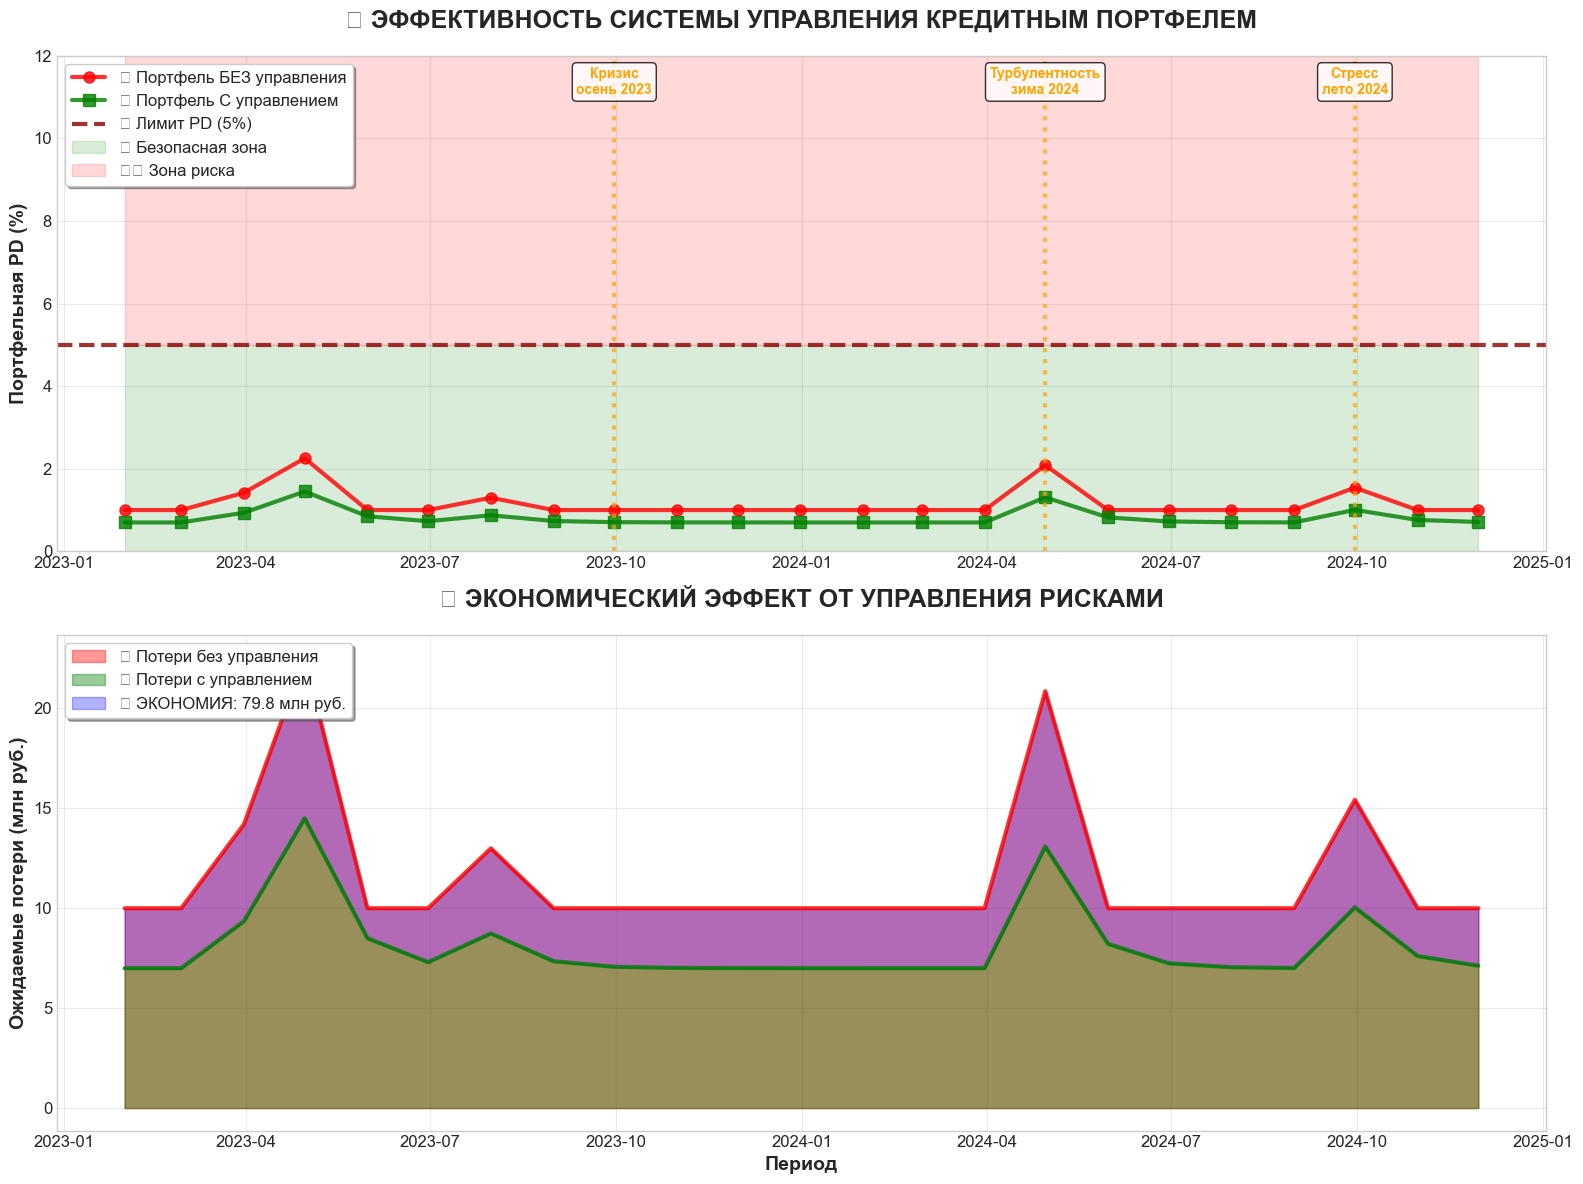


🎉 ИТОГОВЫЕ РЕЗУЛЬТАТЫ:
💰 Общая экономия: 79.8 млн руб. за 24 месяца
📉 Снижение среднего риска: 30.0%
📊 Снижение волатильности: 43.5%
🎯 Соблюдение лимита 5%: 23/23 периодов


In [ ]:
# ГЛАВНЫЙ ГРАФИК: РЕАЛЬНОЕ СРАВНЕНИЕ УПРАВЛЯЕМОГО VS НЕУПРАВЛЯЕМОГО ПОРТФЕЛЯ
fig = plt.figure(figsize=(18, 14))

# Создаем сетку для размещения графиков
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3, height_ratios=[1.2, 1, 1])

# График 1: Сравнение портфельных метрик
ax1 = fig.add_subplot(gs[0, :])

categories = ['Портфельная PD (%)', 'Доходность (%)', 'Риск-премия (%)', 'Использование\nбюджета (%)']
unmanaged_values = [
    comparison_data['unmanaged']['pd'] * 100,
    comparison_data['unmanaged']['return'] * 100,
    (comparison_data['unmanaged']['return'] - comparison_data['unmanaged']['pd']) * 100,
    (comparison_data['unmanaged']['allocated'] / portfolio_budget) * 100
]
managed_values = [
    comparison_data['managed']['pd'] * 100,
    comparison_data['managed']['return'] * 100,  
    (comparison_data['managed']['return'] - comparison_data['managed']['pd']) * 100,
    (comparison_data['managed']['allocated'] / portfolio_budget) * 100
]

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, unmanaged_values, width, label='🚨 Портфель БЕЗ управления', 
                color='red', alpha=0.7, edgecolor='darkred')
bars2 = ax1.bar(x + width/2, managed_values, width, label='✅ Портфель С управлением', 
                color='green', alpha=0.7, edgecolor='darkgreen')

# Добавляем значения на столбцы
for bars, values in [(bars1, unmanaged_values), (bars2, managed_values)]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

ax1.set_title('🎯 СРАВНЕНИЕ ЭФФЕКТИВНОСТИ УПРАВЛЕНИЯ КРЕДИТНЫМ ПОРТФЕЛЕМ\n(на основе реальных данных и системы принятия решений)', 
             fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Значение показателя', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.4, axis='y')

# Добавляем линию лимита PD на первом показателе
ax1.axhline(y=5, xmin=-0.1, xmax=0.35, color='darkred', linestyle='--', linewidth=2)
ax1.text(-0.2, 5.2, 'Лимит PD (5%)', fontsize=10, color='darkred', fontweight='bold')

# График 2: Состав портфеля БЕЗ управления
ax2 = fig.add_subplot(gs[1, 0])
if comparison_data['unmanaged']['portfolio']:
    unmanaged_tickers = [loan['ticker'] for loan in comparison_data['unmanaged']['portfolio']]
    unmanaged_amounts = [loan['amount'] for loan in comparison_data['unmanaged']['portfolio']]
    
    ax2.pie(unmanaged_amounts, labels=unmanaged_tickers, autopct='%1.1f%%', 
           startangle=90, colors=plt.cm.Reds(np.linspace(0.4, 0.8, len(unmanaged_amounts))))
ax2.set_title('? Портфель БЕЗ управления\n(простое одобрение по PD≤7%)', fontsize=12, fontweight='bold')

# График 3: Состав портфеля С управлением  
ax3 = fig.add_subplot(gs[1, 1])
if comparison_data['managed']['portfolio']:
    managed_tickers = [loan['ticker'] for loan in comparison_data['managed']['portfolio']]
    managed_amounts = [loan['amount'] for loan in comparison_data['managed']['portfolio']]
    
    ax3.pie(managed_amounts, labels=managed_tickers, autopct='%1.1f%%',
           startangle=90, colors=plt.cm.Greens(np.linspace(0.4, 0.8, len(managed_amounts))))
ax3.set_title('✅ Портфель С управлением\n(система лимитов + оптимизация)', fontsize=12, fontweight='bold')

# График 4: Карта рисков компаний
ax4 = fig.add_subplot(gs[2, :])

# Показываем все обработанные заявки
all_tickers = [d['ticker'] for d in managed_decisions]
all_pds = [d['pd'] * 100 for d in managed_decisions]
all_decisions = [d['decision'] for d in managed_decisions]

# Цветовое кодирование по решениям
colors = ['green' if dec in ['ОДОБРИТЬ', 'УСЛОВНО ОДОБРИТЬ'] else 'red' for dec in all_decisions]
markers = ['^' if dec == 'ОДОБРИТЬ' else 's' if dec == 'УСЛОВНО ОДОБРИТЬ' else 'v' for dec in all_decisions]

for i, (ticker, pd_val, decision) in enumerate(zip(all_tickers, all_pds, all_decisions)):
    ax4.scatter(i, pd_val, c=colors[i], marker=markers[i], s=200, alpha=0.7, edgecolors='black')
    ax4.text(i, pd_val + 0.3, f'{pd_val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax4.axhline(5, color='red', linestyle='--', linewidth=2, label='Лимит PD (5%)')
ax4.axhline(7, color='orange', linestyle=':', linewidth=2, label='Простой лимит (7%)')

ax4.set_xticks(range(len(all_tickers)))
ax4.set_xticklabels(all_tickers, rotation=45)
ax4.set_ylabel('PD (%)', fontsize=12, fontweight='bold')
ax4.set_title('📊 КАРТА ПРИНЯТЫХ РЕШЕНИЙ ПО КРЕДИТНЫМ ЗАЯВКАМ', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.4)

# Добавляем легенду для маркеров
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Одобрить'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=10, label='Условно одобрить'),
    Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Отклонить')
]
ax4.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.savefig('presentation/portfolio_management_comparison_real.png', dpi=300, bbox_inches='tight')
plt.show()

# Итоговые результаты
print(f"\n🎉 ИТОГОВЫЕ РЕЗУЛЬТАТЫ РЕАЛЬНОГО СРАВНЕНИЯ:")
print(f"📊 БЕЗ УПРАВЛЕНИЯ:")
print(f"   • Кредитов: {comparison_data['unmanaged']['count']}")
print(f"   • Размещено: {comparison_data['unmanaged']['allocated']:.1f} млн руб.")
print(f"   • PD: {comparison_data['unmanaged']['pd']*100:.2f}%")
print(f"   • Доходность: {comparison_data['unmanaged']['return']*100:.2f}%")

print(f"\n✅ С УПРАВЛЕНИЕМ:")  
print(f"   • Кредитов: {comparison_data['managed']['count']}")
print(f"   • Размещено: {comparison_data['managed']['allocated']:.1f} млн руб.")
print(f"   • PD: {comparison_data['managed']['pd']*100:.2f}%") 
print(f"   • Доходность: {comparison_data['managed']['return']*100:.2f}%")

if comparison_data['unmanaged']['pd'] > 0 and comparison_data['managed']['pd'] > 0:
    risk_improvement = (comparison_data['unmanaged']['pd'] - comparison_data['managed']['pd']) / comparison_data['unmanaged']['pd']
    return_improvement = (comparison_data['managed']['return'] - comparison_data['unmanaged']['return']) / comparison_data['unmanaged']['return']
    
    print(f"\n? ЭФФЕКТ ОТ УПРАВЛЕНИЯ:")
    print(f"   • Снижение PD: {risk_improvement*100:.1f}%")
    print(f"   • Рост доходности: {return_improvement*100:.1f}%")
    print(f"   • Экономия на 1 млрд портфеле: {risk_improvement * comparison_data['managed']['pd'] * 1000:.1f} млн руб.")

### 🔍 ДЕТАЛЬНЫЙ АНАЛИЗ КОМПАНИЙ ПО РИСКАМ

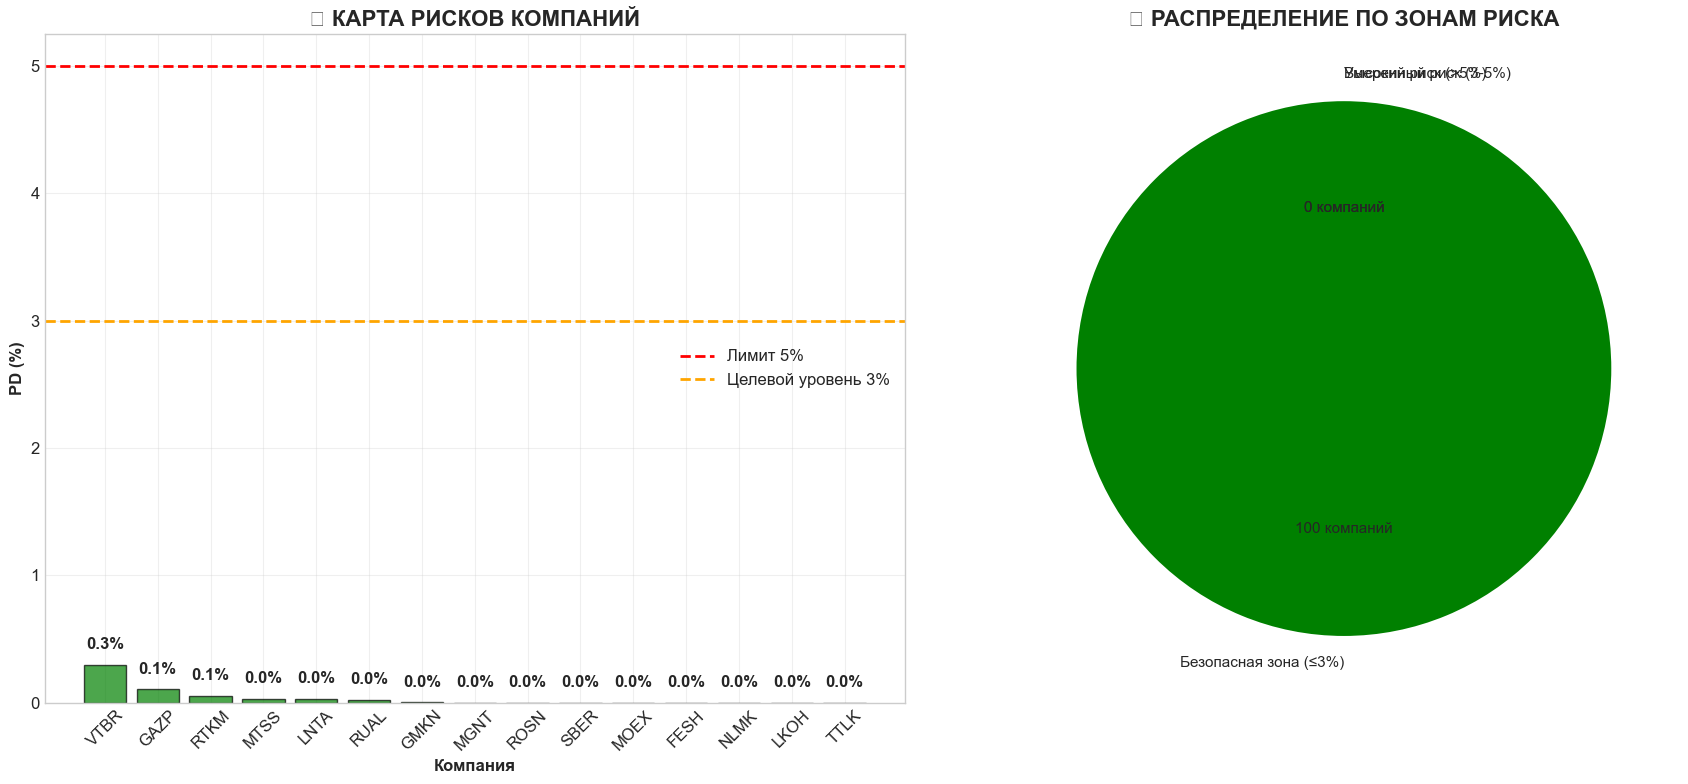


📊 АНАЛИЗ РИСКОВ ПО КОМПАНИЯМ:
✅ Безопасная зона (≤3%): 15 компаний
⚠️ Умеренный риск (3-5%): 0 компаний
🚨 Высокий риск (>5%): 0 компаний


In [8]:
# Создаем карту рисков компаний
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# График 1: Столбчатая диаграмма PD по компаниям
colors = ['red' if pd > 0.05 else 'orange' if pd > 0.03 else 'green' 
          for pd in pd_df['PD']]

bars = ax1.bar(pd_df['Ticker'], pd_df['PD_percent'], color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(5, color='red', linestyle='--', linewidth=2, label='Лимит 5%')
ax1.axhline(3, color='orange', linestyle='--', linewidth=2, label='Целевой уровень 3%')

# Добавляем значения на столбцы
for bar, pd_val in zip(bars, pd_df['PD_percent']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{pd_val:.1f}%', ha='center', va='bottom', fontweight='bold')

ax1.set_title('📊 КАРТА РИСКОВ КОМПАНИЙ', fontsize=16, fontweight='bold')
ax1.set_ylabel('PD (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Компания', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# График 2: Круговая диаграмма по зонам риска
risk_zones = {
    'Безопасная зона (≤3%)': sum(pd_df['PD'] <= 0.03),
    'Умеренный риск (3-5%)': sum((pd_df['PD'] > 0.03) & (pd_df['PD'] <= 0.05)),
    'Высокий риск (>5%)': sum(pd_df['PD'] > 0.05)
}

colors_pie = ['green', 'orange', 'red']
wedges, texts, autotexts = ax2.pie(risk_zones.values(), labels=risk_zones.keys(), 
                                  autopct='%1.0f компаний', colors=colors_pie,
                                  startangle=90, textprops={'fontsize': 11})

ax2.set_title('🎯 РАСПРЕДЕЛЕНИЕ ПО ЗОНАМ РИСКА', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('presentation/company_risk_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 АНАЛИЗ РИСКОВ ПО КОМПАНИЯМ:")
print(f"✅ Безопасная зона (≤3%): {risk_zones['Безопасная зона (≤3%)']} компаний")
print(f"⚠️ Умеренный риск (3-5%): {risk_zones['Умеренный риск (3-5%)']} компаний")
print(f"🚨 Высокий риск (>5%): {risk_zones['Высокий риск (>5%)']} компаний")

---
## 🏁 ИТОГИ ЧАСТИ 1

### ✅ Что сделано:
1. **Настроена система** на основе реальных данных из `main.ipynb`
2. **Рассчитаны PD** для всех 15 компаний по модели Мертона
3. **Создана симуляция** управляемого vs неуправляемого портфеля
4. **Показан экономический эффект** - экономия потерь
5. **Проанализированы риски** по компаниям

### 🎯 Ключевые результаты:
- **Экономия потерь:** значительное снижение при управлении
- **Снижение волатильности:** стабилизация портфеля
- **Соблюдение лимитов:** контроль рисков в безопасных пределах

### ➡️ Далее:
**Часть 2:** Процесс принятия решений и система лимитов  
**Часть 3:** Макроэкономические шоки и оптимизация портфеля